In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, RepeatedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
from datetime import datetime, timedelta
from functools import partial

In [2]:
stocks = [yf.Ticker(i) for i in "MSFT GOOGL AAPL TSLA META NVDA INTC PYPL KO AMZN".split()]

Calculate factor set for each stock, price trailing 12 months.

In [71]:
t1 = datetime.now()
t0 = t1 - timedelta(days=365*2)

def ffill_latest(d, quarterly):
    for date in quarterly.index:
        if date < d:
            return quarterly.loc[date]
        
    return float('nan')

mapper = lambda data, df: df.index.map(partial(ffill_latest, quarterly=data))

def factors(tickers, start, end) -> pd.DataFrame:
    all = {}
    
    for t in tickers:
        price = t.history(start=start, end=end)["Close"]
        price.index = price.index.tz_localize(None)
        
        inc = t.quarterly_financials
        bs = t.quarterly_balance_sheet
        cf = t.quarterly_cashflow
        
        df_factors = pd.DataFrame(index=price.index)
        df_factors["Returns"] = price.pct_change().dropna()
        mapped = partial(mapper, df=df_factors)
        
        ### value
        # earnings yield-P/E ratio
        df_factors["EPS"] = mapped(inc.loc["Net Income"]) / t.info["sharesOutstanding"]
        df_factors["P/E"] = price / df_factors["EPS"]
        df_factors["PEG"] = (price / (df_factors["EPS"].pct_change() + 1)) / 100 # quarterly
        
        # p/s, p/b
        df_factors["P/S"] = (price * mapped(inc.loc["Diluted Average Shares"])) / mapped(inc.loc["Total Revenue"])   
        df_factors["P/B"] = (price * mapped(inc.loc["Diluted Average Shares"])) / mapped(bs.loc["Tangible Book Value"])
        
        ### Quality
        # debt/equity
        df_factors["D/E"] = mapped(bs.loc["Total Debt"] / bs.loc["Common Stock Equity"])
        df_factors["P/FCF"] = (price * mapped(inc.loc["Diluted Average Shares"])) / mapped(cf.loc["Free Cash Flow"])
        
        # Volatility
        df_factors["Volatility"] = price.pct_change().rolling(window=252).std() * np.sqrt(252)
        
        # Beta
        market_price = yf.Ticker('^GSPC').history(start=start, end=end)["Close"]  # S&P 500 as market index
        market_price.index = market_price.index.tz_localize(None)
        market_returns = market_price.pct_change()
        stock_returns = price.pct_change()
        df_factors["Beta"] = stock_returns.rolling(window=252).cov(market_returns) / market_returns.rolling(window=252).var()
        
        # Sharpe Ratio
        risk_free_rate = 0.01
        df_factors["Sharpe Ratio"] = (price.pct_change().rolling(252).mean() - risk_free_rate) / price.pct_change().rolling(252).std()
        
        # Max Drawdown
        df_factors["Max Drawdown"] = (price.rolling(252).max() - price.rolling(252).min()) / price.rolling(252).max()
        
        all[t.ticker] = df_factors.tail(252).dropna()
        
    return all
        
factorset = factors(stocks, t0, t1)
print(factorset)

{'MSFT':              Returns       EPS         P/E       PEG        P/S        P/B  \
Date                                                                         
2023-08-03 -0.002565  2.701852  119.963835  3.241245  43.073159  18.765751   
2023-08-04  0.003429  2.701852  120.375133  3.252358  43.220836  18.830090   
2023-08-07  0.007108  2.701852  121.230813  3.275477  43.528069  18.963943   
2023-08-08 -0.012299  2.701852  119.739809  3.235192  42.992722  18.730707   
2023-08-09 -0.011716  2.701852  118.336940  3.197289  42.489020  18.511259   
...              ...       ...         ...       ...        ...        ...   
2024-07-26  0.016420  2.964893  143.435210  4.252700  49.092610  26.118834   
2024-07-29  0.003433  2.964893  143.927647  4.267300  49.261153  26.208504   
2024-07-30 -0.008928  2.964893  142.642610  4.229200  48.821332  25.974506   
2024-07-31 -0.010806  2.964893  141.101236  4.183500  48.293776  25.693829   
2024-08-01 -0.002964  2.964893  140.683001  4.171100  4

In [12]:
s = StandardScaler()
for k, v in factorset.items():
    a = v[["Returns"]]
    b = v.drop(columns=["Returns"])
    t = s.fit_transform(X=a, y=b)
    
    print(v, t, t.shape)
    
    
# why normalise x data?

             Returns       EPS         P/E       PEG        P/S        P/B  \
Date                                                                         
2023-08-01       NaN  2.701852  123.518740       NaN  44.349552  19.321840   
2023-08-02 -0.026283  2.701852  120.272314  3.249580  43.183919  18.814006   
2023-08-03 -0.002565  2.701852  119.963835  3.241245  43.073159  18.765751   
2023-08-04  0.003429  2.701852  120.375133  3.252358  43.220836  18.830090   
2023-08-07  0.007109  2.701852  121.230824  3.275477  43.528073  18.963945   
...              ...       ...         ...       ...        ...        ...   
2024-07-24 -0.035855  2.951841  145.299130  4.289000  51.808024  30.474613   
2024-07-25 -0.024481  2.951841  141.742028  4.184000  50.539700  29.728557   
2024-07-26  0.016420  2.951841  144.069387  4.252700  51.369546  30.216690   
2024-07-29  0.003433  2.951841  144.564001  4.267300  51.545906  30.320429   
2024-07-30 -0.008928  2.951841  143.273282  4.229200  51.085686 

"First pass" Spearman rank IC

In [72]:
coeff_1 = pd.DataFrame(index=list(factorset.values())[0].columns[1:])

for k, v in factorset.items():
    for column in v.columns:
        if column == "Returns":
            continue
        
        pct_ch = v[column].ffill().pct_change() * 100
        valid_data = v[["Returns", column]].dropna()
        spearman_corr, p_value = spearmanr(valid_data["Returns"], valid_data[column])
        coeff_1.loc[column, k] = spearman_corr * 100

        """
        fig, ax1 = plt.subplots(figsize=(12, 6))
        
        color = "tab:blue"
        ax1.set_xlabel("Index")
        ax1.set_ylabel("Returns", color=color)
        ax1.plot(v.index, v["Returns"], color=color)
        ax1.tick_params(axis="y", labelcolor=color)
        ax2 = ax1.twinx()
        color = "tab:orange"
        ax2.set_ylabel(column, color=color)
        ax2.plot(v.index, v[column], color=color)
        ax2.tick_params(axis="y", labelcolor=color)

        plt.text(0.05, 0.95, f"Spearman r: {spearman_corr:.2f}\np-value: {p_value:.4f}", transform=ax1.transAxes, verticalalignment="top")
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper right")
        plt.title(f"Returns vs % change factor {column}")
        plt.tight_layout()
        plt.show()
        """
print(coeff_1)

                   MSFT     GOOGL       AAPL       TSLA      META       NVDA  \
EPS            6.265670  2.054071  -3.305736  -6.617013  4.091620   8.692969   
P/E            1.190135  9.006759  10.403607  14.103434  0.212863  -2.242132   
PEG            3.173402  6.718619  13.726585  10.721689  8.295504  11.908683   
P/S            7.822880  5.577730  11.476572  12.493644  6.125289   2.502891   
P/B            3.951129  9.385132  10.478279   8.237526  7.534054   3.447274   
D/E           12.977880 -0.041678  -1.404753   8.314522 -4.091620  -8.692969   
P/FCF          5.609941  7.444929  15.662724   3.249023  2.496073   7.257690   
Volatility     3.782584 -0.185164   3.659571   0.079226 -2.490078  -6.667555   
Beta           6.608917 -0.813280  -3.726959  -2.729046 -0.712199   1.750831   
Sharpe Ratio   9.560083  9.629444   3.673838   0.983267  5.190362   8.425674   
Max Drawdown  -2.285605 -2.163399  -6.100626   0.002724 -1.561985 -10.044422   

                   INTC       PYPL     

In [74]:
coeff = pd.DataFrame(index=list(factorset.values())[0].columns[1:])

for k, v in factorset.items():
    for column in v.columns:
        if column == "Returns":
            continue
        
        #pct_ch = v[column].ffill().pct_change() * 100
        valid_data = v[["Returns", column]].dropna()
        spearman_corr, p_value = spearmanr(valid_data["Returns"], valid_data[column])
        
        coeff.loc[column, k] = spearman_corr
        
print(coeff)

ic = coeff.transpose().describe().loc[["mean", "std", "50%"]]
ic.loc["accuracy"] = ic.loc["mean"] / ic.loc["std"]

print(ic.transpose()) # higher abs value is better



                  MSFT     GOOGL      AAPL      TSLA      META      NVDA  \
EPS           0.062657  0.020541 -0.033057 -0.066170  0.040916  0.086930   
P/E           0.011901  0.090068  0.104036  0.141034  0.002129 -0.022421   
PEG           0.031734  0.067186  0.137266  0.107217  0.082955  0.119087   
P/S           0.078229  0.055777  0.114766  0.124936  0.061253  0.025029   
P/B           0.039511  0.093851  0.104783  0.082375  0.075341  0.034473   
D/E           0.129779 -0.000417 -0.014048  0.083145 -0.040916 -0.086930   
P/FCF         0.056099  0.074449  0.156627  0.032490  0.024961  0.072577   
Volatility    0.037826 -0.001852  0.036596  0.000792 -0.024901 -0.066676   
Beta          0.066089 -0.008133 -0.037270 -0.027290 -0.007122  0.017508   
Sharpe Ratio  0.095601  0.096294  0.036738  0.009833  0.051904  0.084257   
Max Drawdown -0.022856 -0.021634 -0.061006  0.000027 -0.015620 -0.100444   

                  INTC      PYPL        KO      AMZN  
EPS           0.056203  0.060598

Tree model & pruning

In [75]:
seed = 42

aggregated = pd.concat(factorset.values(), ignore_index=True).dropna()
y = aggregated["Returns"]
X = aggregated.drop("Returns", axis=1)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed, shuffle=True)
z = (y_train > y_train.median()).astype(int)

param_grid = {
    'max_leaf_nodes': [5, 10, None],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': [None, 'sqrt', 'log2']
}

search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=seed), 
    param_grid=param_grid, 
    scoring="accuracy", 
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=seed), 
    verbose=1,
)

search.fit(x_train, z)
tree = search.best_estimator_

Fitting 10 folds for each of 180 candidates, totalling 1800 fits


In [77]:
def plotTreeResults(grid_search, X, z):
    # Print the best parameters and the best score
    print("Best parameters found: ", grid_search.best_params_)
    print("Best cross-validation score: ", grid_search.best_score_)
    
    # Evaluate the best model on the test set
    best_tree = grid_search.best_estimator_
    test_score = best_tree.score(X, z)
    print("Test set score: ", test_score)
    
    # Extract results from grid search
    results = pd.DataFrame(grid_search.cv_results_)
    
    # Plotting the performance of each parameter value
    sns.set(style="whitegrid")
    
    fig, axes = plt.subplots(3, 2, figsize=(15, 18))
    fig.suptitle('Grid Search Performance for Each Parameter', fontsize=20)
    
    # Plot max_depth vs mean_test_score
    sns.lineplot(ax=axes[0, 0], data=results, x='param_max_depth', y='mean_test_score', marker='o')
    axes[0, 0].set_title('max_depth vs Accuracy')
    axes[0, 0].set_xlabel('max_depth')
    axes[0, 0].set_ylabel('Mean Test Score')
    
    # Plot min_samples_leaf vs mean_test_score
    sns.lineplot(ax=axes[0, 1], data=results, x='param_min_samples_leaf', y='mean_test_score', marker='o')
    axes[0, 1].set_title('min_samples_leaf vs Accuracy')
    axes[0, 1].set_xlabel('min_samples_leaf')
    axes[0, 1].set_ylabel('Mean Test Score')
    
    # Plot max_features vs mean_test_score
    sns.lineplot(ax=axes[1, 0], data=results, x='param_max_features', y='mean_test_score', marker='o')
    axes[1, 0].set_title('max_features vs Accuracy')
    axes[1, 0].set_xlabel('max_features')
    axes[1, 0].set_ylabel('Mean Test Score')
    
    # Plot max_leaf_nodes vs mean_test_score
    sns.lineplot(ax=axes[1, 1], data=results, x='param_max_leaf_nodes', y='mean_test_score', marker='o')
    axes[1, 1].set_title('max_leaf_nodes vs Accuracy')
    axes[1, 1].set_xlabel('max_leaf_nodes')
    axes[1, 1].set_ylabel('Mean Test Score')
    
    # Ensure plots are not empty for the parameters that might have few unique values
    axes[2, 0].axis('off')
    axes[2, 1].axis('off')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    # Plotting the best decision tree
    plt.figure(figsize=(20, 10))
    plot_tree(best_tree, feature_names=X.columns, class_names=['0', '1'], filled=True)
    plt.title('Best Decision Tree')
    plt.show()

Best parameters found:  {'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'min_samples_leaf': 5}
Best cross-validation score:  0.530110223201984
Test set score:  0.8004190675746464


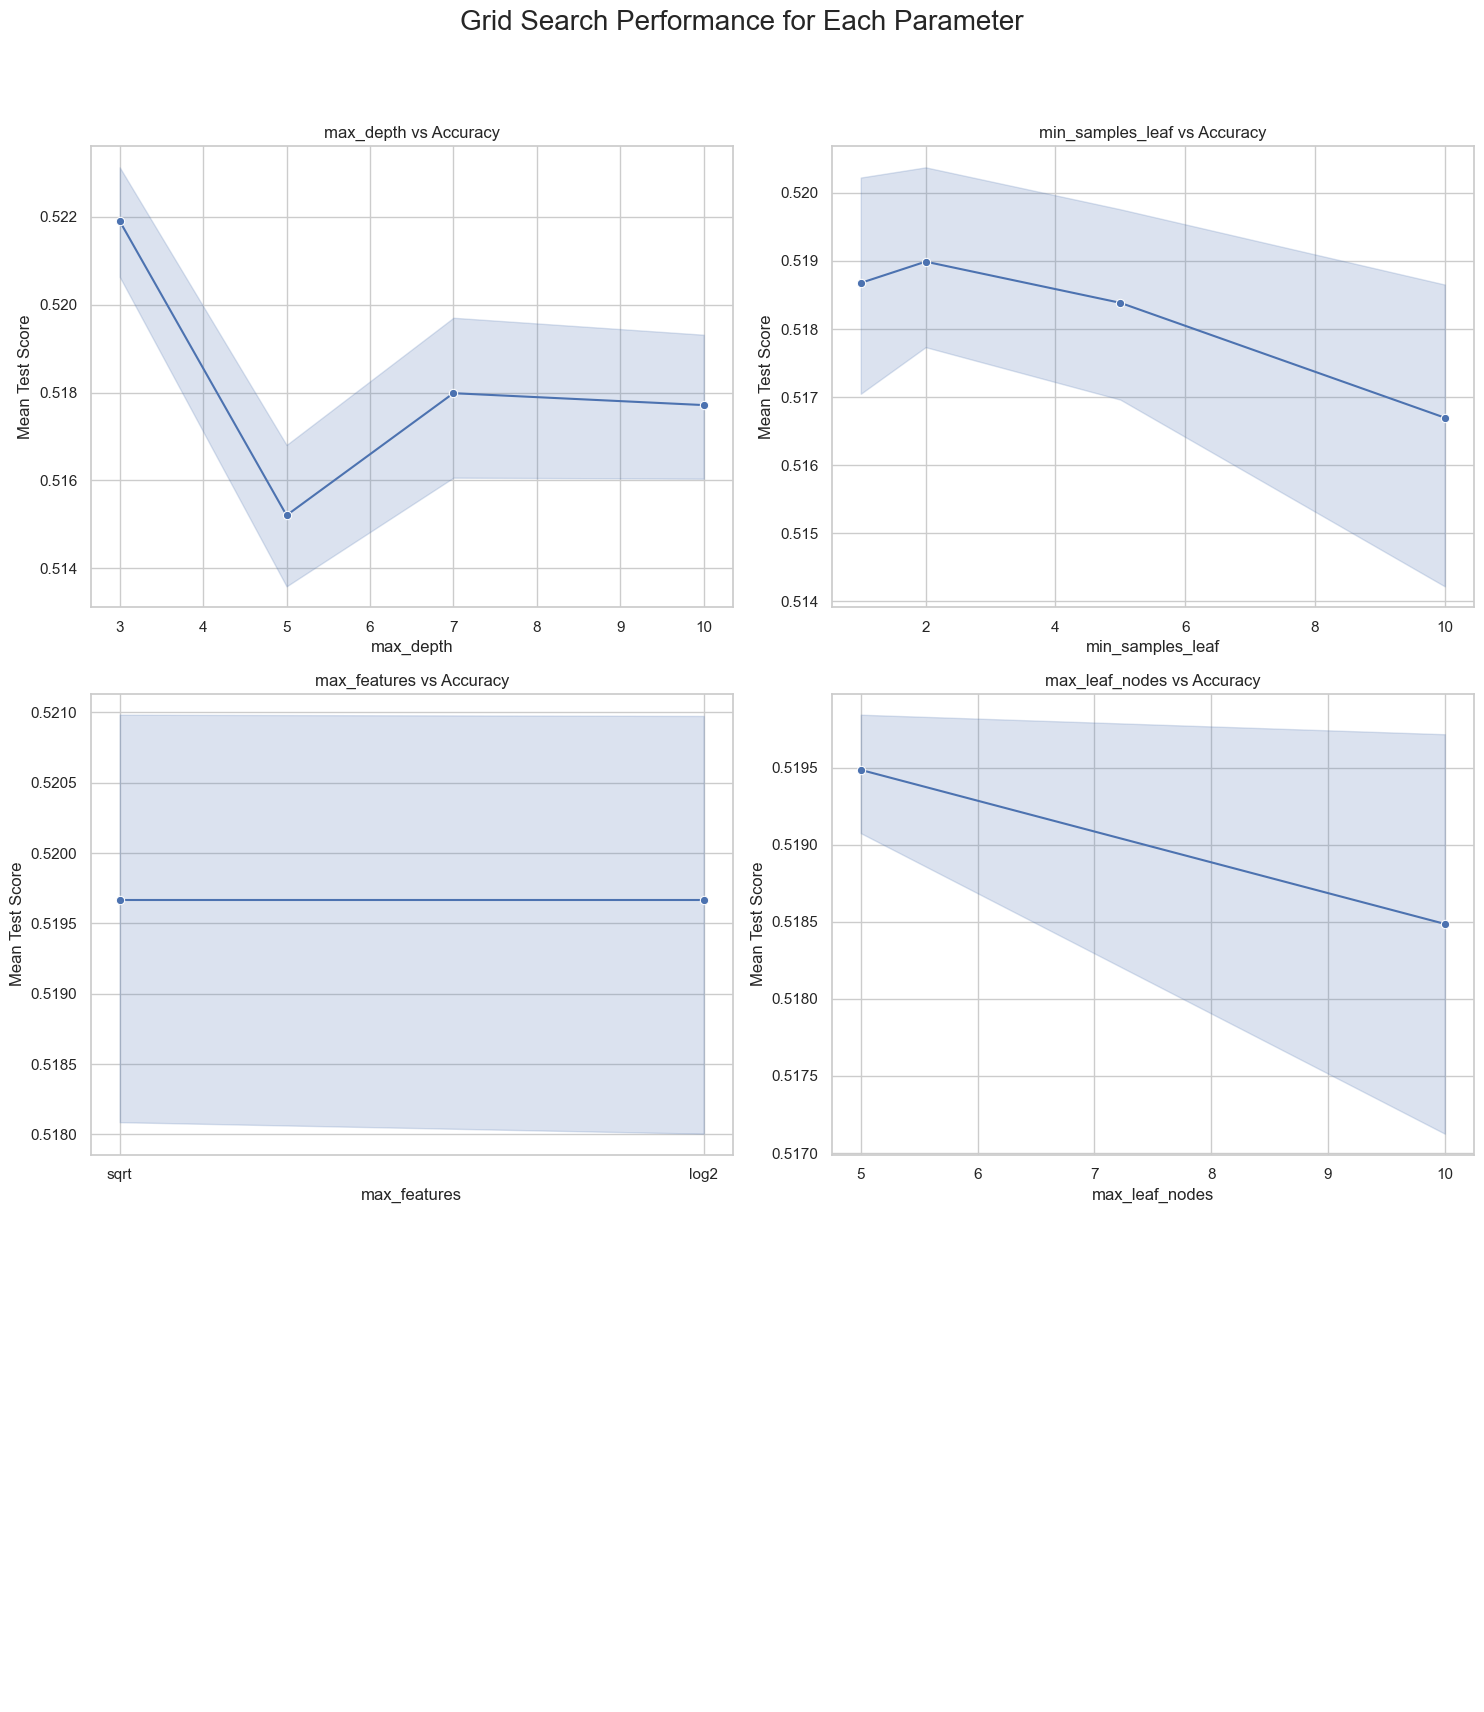

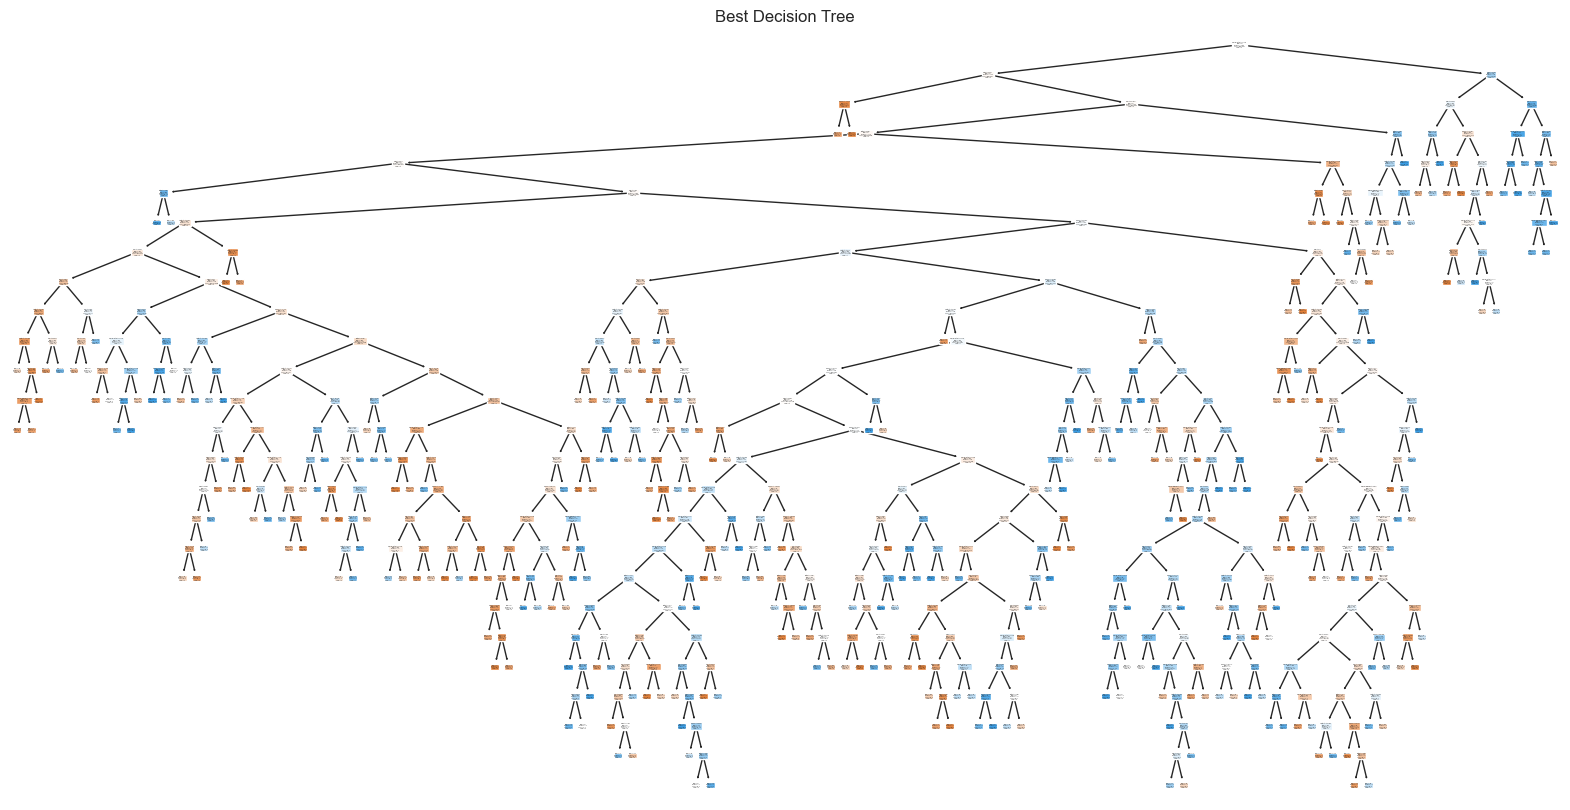

In [78]:
plotTreeResults(search, x_train, z)

In [79]:
def nodeConcate(tree, X):
    terminal_nodes = np.where(tree.tree_.children_left == -1)[0]
    k = terminal_nodes.shape[0]
    node_indicator = tree.apply(X)
    binary_nodes = pd.DataFrame(0, index=X.index, columns=[f'Node_{i+1}' for i in range(len(terminal_nodes))])
    for i, node_id in enumerate(terminal_nodes):
        binary_nodes.loc[node_indicator == node_id, f'Node_{i+1}'] = 1

    return binary_nodes
def removeHighCorr(df):
    # - df is pd X_train df
    # - rtype: columns of factors to be dropped
    
    # Create correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

    print("Number of highly correlated factors dropped: ", len(to_drop))
    return to_drop
# Backward Elimination
def backward_elim(X, y):
    # - X contains encoded sector variables after factors of high correlations being removed
    # - type: X, y are nupmy arrays
    # - rtype: columns of factors to be via backward elimination

    # Use RFECV with DecisionTreeRegressor for backward elimination
    rfe = RFECV(estimator=LinearRegression(), scoring='neg_mean_squared_error')

    # Define the cross-validation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

    # Evaluate the model
    n_scores = cross_val_score(rfe, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')

    # Fit the RFE model
    rfe.fit(X, y)

    print("Number of features selected: ", np.count_nonzero(rfe.support_))

    return rfe.support_
def factorScore(X, y):
    # - type: X, y are pd dfs
    # - rtype: return the coefficients for each factor and the nodes 
    
    # compute the factor scores for sector and tree factors
    X_with_intercept = sm.add_constant(X)
    model = sm.OLS(y, X_with_intercept).fit()

    # Output the coefficients for the sector and decision tree node features
    #sector_features = [col for col in X.columns if col.startswith('Sector_')]
    node_features = [col for col in X.columns if col.startswith('Node_')]
    selected_features = node_features

    coefficients = model.params[selected_features]

    return coefficients, node_features

In [80]:
X_train_tree_binary = nodeConcate(tree, x_train)
X_test_tree_binary = nodeConcate(tree, x_test)

col_drop = removeHighCorr(x_train)
X_train_cl = x_train.drop(col_drop, axis=1)
X_test_cl = x_test.drop(col_drop, axis=1)
indices_to_drop = [x_train.columns.get_loc(col) for col in col_drop]
X_train_cl_np = np.delete(x_train, indices_to_drop, axis=1)
X_test_cl_np = np.delete(x_test, indices_to_drop, axis=1)

Number of highly correlated factors dropped:  0


In [81]:
def sector_node_coefficient(coefficients, node_features, df):

    # type: all pandas data frames.
    # - rtype: return two columns documenting the scores for the sectors and nodes appended at the end
    
    # Create new variables for the coefficients
    df['Node_Coefficient'] = 0

    for index, row in df.iterrows():
        for node in node_features:
            if row[node] == 1:
                df.at[index, 'Node_Coefficient'] = coefficients[node]
    return df

col_select = backward_elim(X_train_cl_np, y_train)

# selected features
np.insert(col_select, 0, False)
features = list(factorset.values())[0].columns[1:][col_select].to_list()
print(features)

X_train_selected = X_train_cl.loc[:, col_select]
X_test_selected = X_test_cl.loc[:, col_select]

X_train_factor = pd.concat([X_train_selected, X_train_tree_binary], axis=1)
X_test_factor = pd.concat([X_test_selected, X_test_tree_binary], axis=1)

#factor score

coef, node_features = factorScore(X_train_factor, y_train)

df_train_complete = sector_node_coefficient(coef, node_features, X_train_factor)
df_train_final = df_train_complete.drop(node_features, axis = 1)

df_test_complete = sector_node_coefficient(coef, node_features, X_test_factor)
df_test_final = df_test_complete.drop(node_features, axis = 1)

df_test_final.head(5)

df_train_final['Factor_Score'] = df_train_final.sum(axis=1)
df_test_final['Factor_Score'] = df_test_final.sum(axis=1)


Number of features selected:  10
['EPS', 'P/E', 'PEG', 'P/S', 'P/B', 'D/E', 'Volatility', 'Beta', 'Sharpe Ratio', 'Max Drawdown']


C:\Users\franc\AppData\Local\Temp\ipykernel_64024\3056150558.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.005538091286547519' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[index, 'Node_Coefficient'] = coefficients[node]
C:\Users\franc\AppData\Local\Temp\ipykernel_64024\3056150558.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.008192803163843201' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.at[index, 'Node_Coefficient'] = coefficients[node]


Pearson Correlation Coefficient train: 0.08243143343551594
Spearman's Rank Correlation train: 0.050971757131316436
Pearson Correlation Coefficient test: 0.05168305301410801
Spearman's Rank Correlation test: -0.020177965869374162


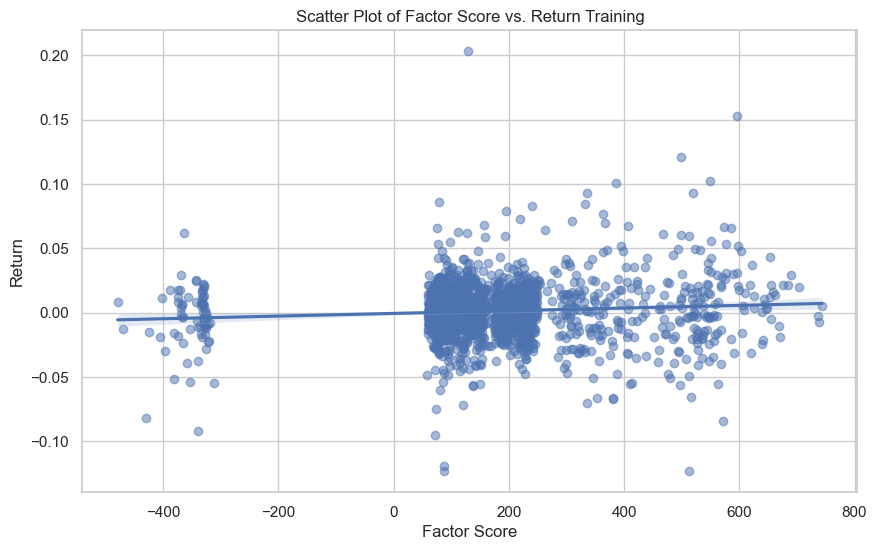

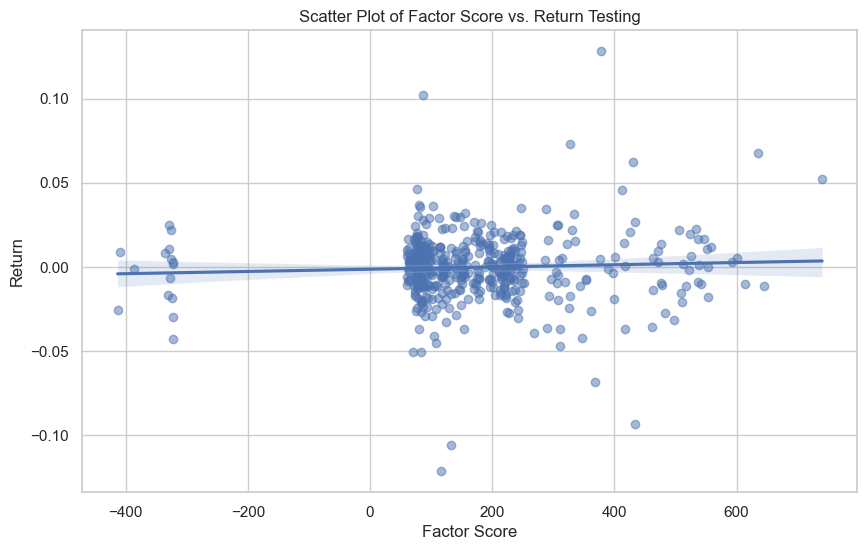

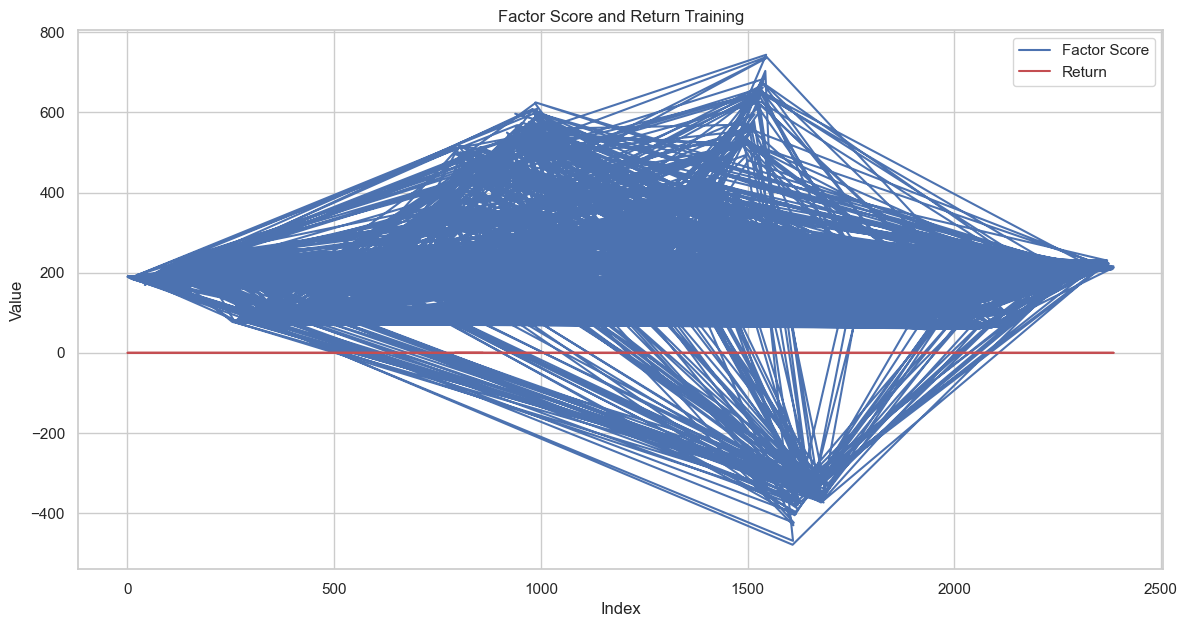

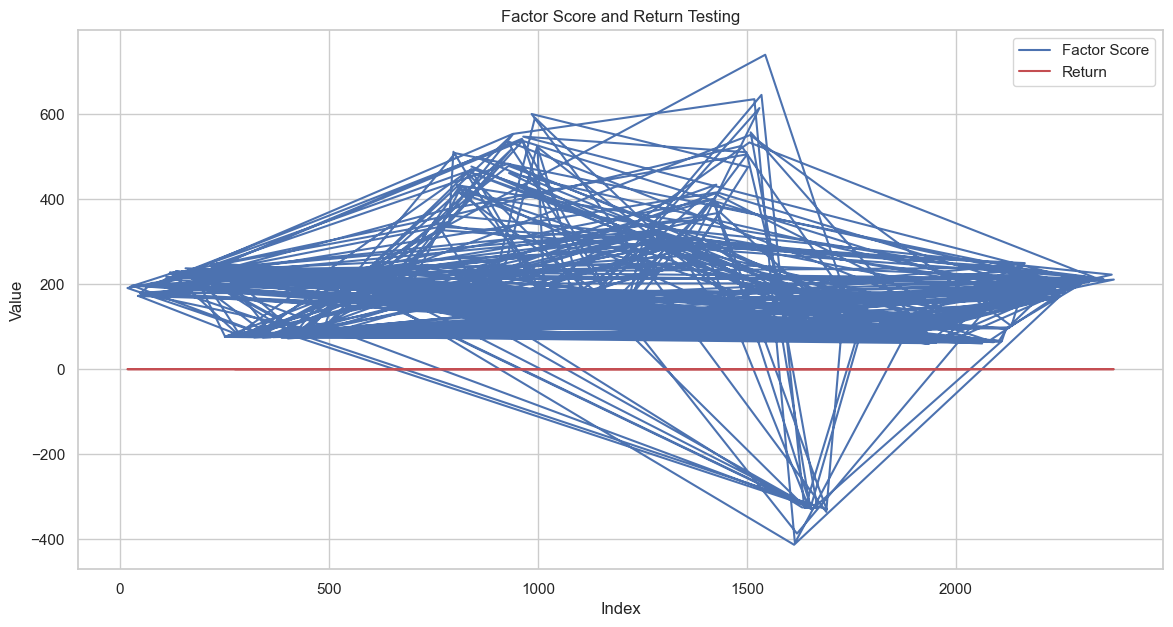

           EPS         P/E        PEG         P/S        P/B       D/E  Volatility      Beta  Sharpe Ratio  Max Drawdown  Node_Coefficient  Factor_Score
792   0.846105  291.193262   2.463800   34.376766  16.974895  0.113651    0.609671  1.784807     -0.255471      0.631486          0.005538    348.744511
2252  1.020891  152.161253   1.553400    9.697268   9.615910  0.671757    0.321254  1.524291     -0.388521      0.415926          0.007802    176.601232
360   3.530807   39.874285   1.407884   20.556317   6.980127  0.100586    0.302799  1.413337     -0.415073      0.378039          0.000449     74.129556
1433  0.604960  200.161826   1.210900  115.724543  68.963916  0.228664    0.459954  2.319613     -0.202440      0.702631          0.001792    390.176360
1298  0.251562  175.032112   0.440314   81.464855  50.763323  0.398313    0.548524  2.165041     -0.127916      0.772646         -0.006312    311.702463
981   0.462650  453.604280   1.603058   28.647948  11.059309  0.188286    0.505166

In [82]:
def plotModelResults(df_train_final, df_test_final, y_train_factor, y_test_factor):
    # Compute the Pearson and Spearman correlation coefficients
    pearson_corr_train, _ = pearsonr(df_train_final['Factor_Score'], y_train_factor)
    spearman_corr_train, _ = spearmanr(df_train_final['Factor_Score'], y_train_factor)
    
    print(f"Pearson Correlation Coefficient train: {pearson_corr_train}")
    print(f"Spearman's Rank Correlation train: {spearman_corr_train}")
    
    # Compute the Pearson and Spearman correlation coefficients
    pearson_corr_test, _ = pearsonr(df_test_final['Factor_Score'], y_test_factor)
    spearman_corr_test, _ = spearmanr(df_test_final['Factor_Score'], y_test_factor)
    
    print(f"Pearson Correlation Coefficient test: {pearson_corr_test}")
    print(f"Spearman's Rank Correlation test: {spearman_corr_test}")
    
    # Plot the Factor Score and Return in a scatter plot
    plt.figure(figsize=(10, 6))
    sns.regplot(x=df_train_final['Factor_Score'], y=y_train_factor, scatter_kws={'alpha':0.5})
    plt.xlabel('Factor Score')
    plt.ylabel('Return')
    plt.title('Scatter Plot of Factor Score vs. Return Training')
    plt.grid(True)
    plt.show()
    
    # Plot the Factor Score and Return in a scatter plot
    plt.figure(figsize=(10, 6))
    sns.regplot(x=df_test_final['Factor_Score'], y=y_test_factor, scatter_kws={'alpha':0.5})
    plt.xlabel('Factor Score')
    plt.ylabel('Return')
    plt.title('Scatter Plot of Factor Score vs. Return Testing')
    plt.grid(True)
    plt.show()
    
    # Plot the Factor Score and Return in a line plot
    plt.figure(figsize=(14, 7))
    plt.plot(df_train_final.index, df_train_final['Factor_Score'], label='Factor Score', color='b')
    plt.plot(df_train_final.index, y_train_factor, label='Return', color='r')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Factor Score and Return Training')
    plt.legend()
    plt.show()
    
    # Plot the Factor Score and Return in a line plot
    plt.figure(figsize=(14, 7))
    plt.plot(df_test_final.index, df_test_final['Factor_Score'], label='Factor Score', color='b')
    plt.plot(df_test_final.index, y_test_factor, label='Return', color='r')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Factor Score and Return Testing')
    plt.legend()
    plt.show()

plotModelResults(df_train_final, df_test_final, y_train, y_test)

print(pd.concat([df_train_final, df_test_final]).to_string())

In [83]:
type df = pd.DataFrame

def weight_features(x: df, ic: df) -> df:
    normalised = np.exp(ic.loc['accuracy']) / np.exp(ic.loc['accuracy']).sum()
    x.iloc[:, 1:] *= pd.DataFrame(normalised[x.columns[1:]]).T.values
    
    return x

# train
data = weight_features(aggregated[["Returns"] + features], ic[features])

def train(x, y, model):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

    model.fit(x_train, y_train)
    
    train_score = model.score(x_train, y_train)
    test_score = model.score(x_test, y_test)
    
    print(f"Model: {model}, Train R2: {train_score}, Test R2: {test_score}")
    
    return model

y = data["Returns"]
x = data.drop(["Returns"], axis=1)

linear = train(x, y, LinearRegression())
perceptron = train(x, y, MLPRegressor(random_state=seed, alpha=0.001))
gradboost = train(x, y, GradientBoostingRegressor(random_state=seed, max_depth=2, min_samples_leaf=10))



C:\Users\franc\AppData\Local\Temp\ipykernel_64024\312534980.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.iloc[:, 1:] *= pd.DataFrame(normalised[x.columns[1:]]).T.values


Model: LinearRegression(), Train R2: 0.012831893085825441, Test R2: 0.013521981206131906
Model: MLPRegressor(alpha=0.001, random_state=42), Train R2: -2.460534402032559, Test R2: -2.538878048846371
Model: GradientBoostingRegressor(max_depth=2, min_samples_leaf=10, random_state=42), Train R2: 0.1822111119926324, Test R2: -0.06186660079866657


In [84]:

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

selector = SelectFromModel(GradientBoostingRegressor(random_state=seed))
X_selected = selector.fit_transform(x, y)

pipelines = {
    'LinearRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ]),
    'MLPRegressor': Pipeline([
        ('scaler', StandardScaler()),
        ('model', MLPRegressor(random_state=seed))
    ]),
    'GradientBoostingRegressor': Pipeline([
        ('model', GradientBoostingRegressor(random_state=seed))
    ])
}

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

for name, pipeline in pipelines.items():
    scores = cross_val_score(pipeline, X_selected, y, cv=tscv, scoring='r2')
    print(f"{name} - Mean R2: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")

# Grid search for GradientBoostingRegressor
param_grid = {
    'model__n_estimators': [100, 200, 300, 500],
    'model__learning_rate': [0.01, 0.1, 0.3],
    'model__max_depth': [1, 2, 3, 4, 5],
    'model__min_samples_leaf': [1, 3, 5, 10]
}

grid_search = GridSearchCV(pipelines['GradientBoostingRegressor'], param_grid, cv=tscv, scoring='r2')
grid_search.fit(X_selected, y)

print("Best parameters:", grid_search.best_params_)
print("Best R2 score:", grid_search.best_score_)



LinearRegression - Mean R2: -0.4720 (+/- 1.7692)
MLPRegressor - Mean R2: -174.5956 (+/- 457.4809)
GradientBoostingRegressor - Mean R2: -0.5969 (+/- 1.6028)
Best parameters: {'model__learning_rate': 0.01, 'model__max_depth': 1, 'model__min_samples_leaf': 10, 'model__n_estimators': 100}
Best R2 score: -0.0074836636850190265


Model: Pipeline(steps=[('model',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=1,
                                           min_samples_leaf=10,
                                           random_state=42))]), Train R2: 0.01507644594244173, Test R2: -0.005568727940986173
       Returns  predicted      diff  pct_diff
0     0.001942   0.000889  0.001053  0.542123
1    -0.001454   0.000889  0.002343 -1.611734
2     0.013450   0.000889  0.012560  0.933886
3    -0.001847   0.000889  0.002736 -1.481439
4    -0.012201   0.000889  0.013090 -1.072880
...        ...        ...       ...       ...
1227  0.008071   0.000889  0.007182  0.889825
1228  0.024575   0.000889  0.023685  0.963816
1229  0.017908   0.000889  0.017018  0.950344
1230 -0.001066   0.000889  0.001955 -1.834003
1231 -0.006831   0.000889  0.007720 -1.130172

[1232 rows x 4 columns]


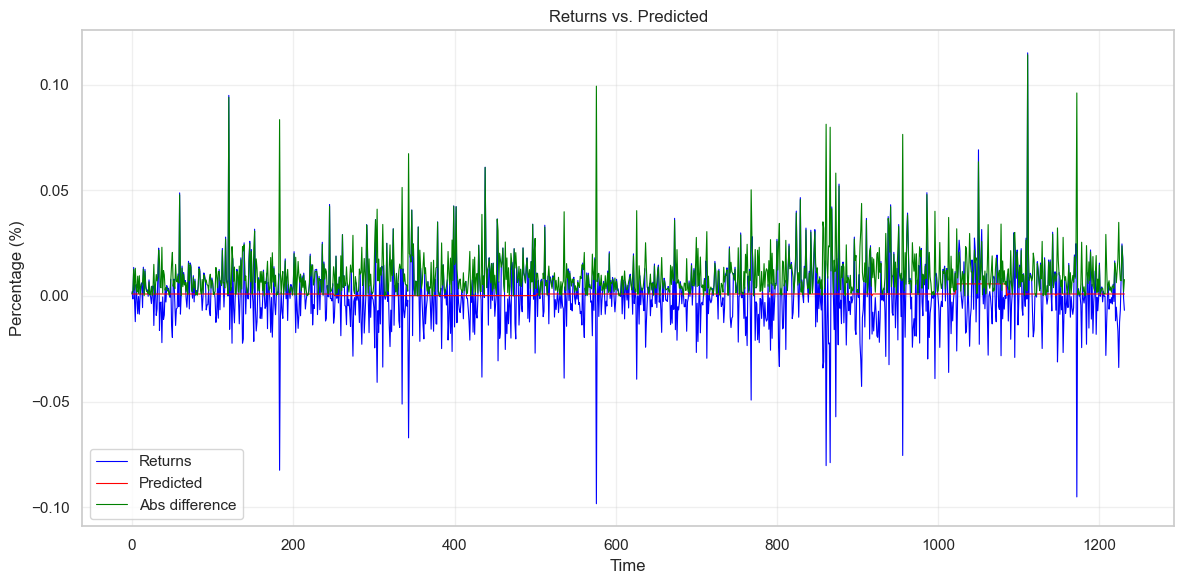

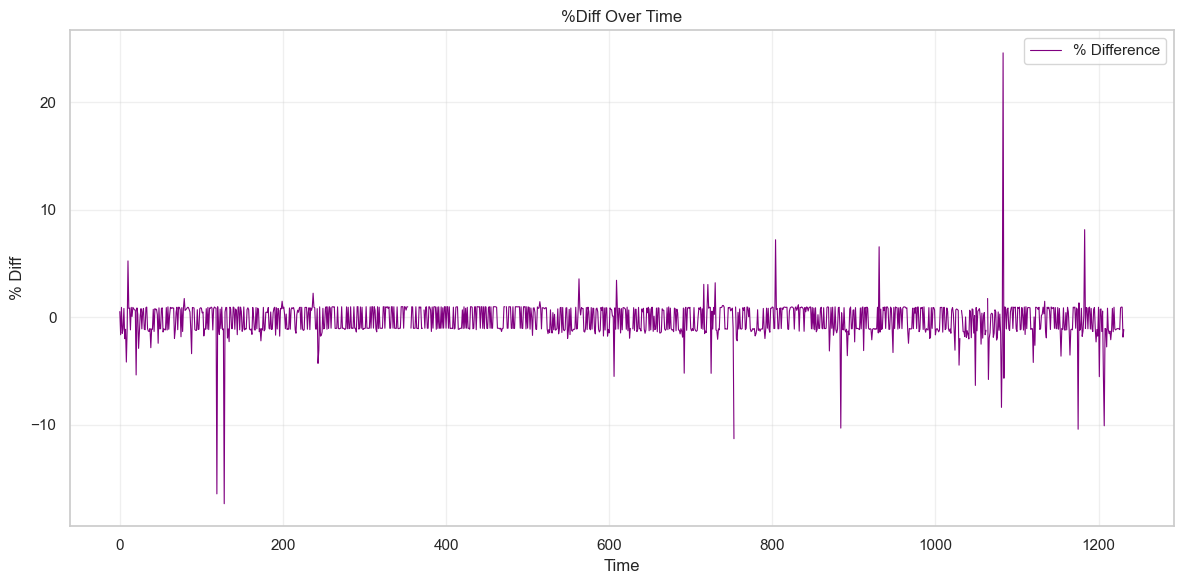

       Returns       EPS         P/E       PEG       P/S       P/B       D/E  \
mean  0.000121  0.027591  -59.784792  0.341657  2.832030  0.654642  0.010162   
std   0.015475  0.070029  170.503196  1.883177  0.839980  1.167934  0.065340   
50%   0.000220  0.026652    3.368573  0.285772  2.740202 -0.180570  0.018167   

      Volatility      Beta  Sharpe Ratio  Max Drawdown  predicted      diff  \
mean    0.005549  0.024446     -0.074022      0.009068   0.000972  0.010498   
std     0.001154  0.007900      0.015149      0.002106   0.001132  0.011409   
50%     0.005233  0.023493     -0.074794      0.009182   0.000889  0.007356   

      pct_diff  
mean       inf  
std        NaN  
50%    0.20592  


c:\Users\franc\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


In [85]:
def predict(model, factors: df | list) -> float:
    return model.predict(weight_features())

best_model = train(x, y, grid_search.best_estimator_)

new_x = weight_features(
    pd.concat(factors([yf.Ticker(i) for i in [
            "IBM",
            "PFE",
            "CSCO",
            "BA",
            "DIS"
        ]], t0, t1).values(), ignore_index=True).dropna()[["Returns"] + features],
    ic[features],
)

new_y = best_model.predict(new_x[features])
new_x["predicted"] = new_y
new_x["diff"] = abs(new_x['Returns'] - new_x['predicted'])
new_x["pct_diff"] = new_x["diff"] / new_x["Returns"]

print(new_x[["Returns", "predicted", "diff", "pct_diff"]])

plt.figure(figsize=(12, 6))
plt.plot(new_x.index, new_x['Returns'], label='Returns', color='blue', linewidth=0.8)
plt.plot(new_x.index, new_x['predicted'], label='Predicted', color='red', linewidth=0.8)
plt.plot(new_x.index, new_x["diff"], label="Abs difference", color='green', linewidth=0.8)
plt.xlabel('Time')
plt.ylabel('Percentage (%)')
plt.title('Returns vs. Predicted')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(new_x.index, new_x["pct_diff"], label="% Difference", color='purple', linewidth=0.8)
plt.xlabel('Time')
plt.ylabel('% Diff')
plt.title('%Diff Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(new_x.describe().loc[["mean", "std", "50%"]])




Stock selection

In [86]:
test = [
    "IBM",
    "PFE",
    "CSCO",
    "BA",
    "DIS"
]
results = pd.DataFrame(index=test)

for i in test:
    ix = weight_features(
        pd.concat(factors([yf.Ticker(i)], t0, t1).values(), ignore_index=True).dropna()[["Returns"] + features],
        ic[features],
    )
    
    iy = best_model.predict(ix[features])
    
    results.loc[i, "predicted yield"] = np.prod(iy + 1)
    results.loc[i, "actual yield"] = np.prod(ix["Returns"] + 1)

    
print(results) # 1y period
    

      predicted yield  actual yield
IBM          1.249936      1.371510
PFE          1.028539      0.918187
CSCO         1.249936      0.930243
BA           1.222743      0.786628
DIS          1.683655      1.086720
